# Network Routing With Bandits

In [ ]:
import numpy as np
import amalearn

In [370]:
from amalearn.reward import RewardBase

class NetReward(RewardBase):
    def __init__(self, sid):
        super(NetReward, self).__init__()
        self.sid = sid

    def link_delay(self, link) :
        if link in ["a1","a3","b1","b7","b11","b12","c5","c6","c11","c12","d3"]:#green loc=self.mean, scale=self.std
            link_delay = np.random.normal(loc=int(sid[-2]), scale=int(sid[-3])+1, size =1)
        
        elif link in ["a2","b2","b3","b4","b9","c3","c4","c7","c8","d1"]:#blue
            link_delay = np.random.normal(loc=int(sid[-1]), scale=int(sid[-2])+0.2, size = 1)

        else:#orange
            link_delay = np.random.normal(loc=int(sid[-3]), scale=int(sid[-4])+0.5, size =1)
        return link_delay

    def node_delay(self,node):
        #node = [1,2,3,4,5,6,7,8,9,10,11]
        node_p = [0.1,0.06, 0.15,0.5,0.1,0.15,0.65,0.12,0.2,0.05,0.45]
        node_index = int(node)-1
        return np.random.binomial(size=1,n=10, p= node_p[node_index]) *10

    def get_reward(self,action):
        link_path = ["a1,1,b1,5,c1,8,d1","a1,1,b1,5,c2,9,d2","a1,1,b1,5,c3,10,d3","a1,1,b1,5,c4,11,d4","a1,1,b2,6,c5,8,d1","a1,1,b2,6,c6,9,d2","a1,1,b2,6,c7,10,d3","a1,1,b2,6,c8,11,d4","a1,1,b3,7,c9,8,d1","a1,1,b3,7,c10,9,d2","a1,1,b3,7,c11,10,d3","a1,1,b3,7,c12,11,d4",
        "a2,2,b4,5,c1,8,d1","a2,2,b4,5,c2,9,d2","a2,2,b4,5,c3,10,d3","a2,2,b4,5,c4,11,d4","a2,2,b5,6,c5,8,d1","a2,2,b5,6,c6,9,d2","a2,2,b5,6,c7,10,d3","a2,2,b5,6,c8,11,d4","a2,2,b6,7,c9,8,d1","a2,2,b6,7,c10,9,d2","a2,2,b6,7,c11,10,d3","a2,2,b6,7,c12,11,d4",
        "a3,3,b7,5,c1,8,d1","a3,3,b7,5,c2,9,d2","a3,3,b7,5,c3,10,d3","a3,3,b7,5,c4,11,d4","a3,3,b8,6,c5,8,d1","a3,3,b8,6,c6,9,d2","a3,3,b8,6,c7,10,d3","a3,3,b8,6,c8,11,d4","a3,3,b9,7,c9,8,d1","a3,3,b9,7,c10,9,d2","a3,3,b9,7,c11,10,d3","a3,3,b9,7,c12,11,d4",
        "a4,4,b10,5,c1,8,d1","a4,4,b10,5,c2,9,d2","a4,4,b10,5,c3,10,d3","a4,4,b10,5,c4,11,d4","a4,4,b11,6,c5,8,d1","a4,4,b11,6,c6,9,d2","a4,4,b11,6,c7,10,d3","a4,4,b11,6,c8,11,d4","a4,4,b12,7,c9,8,d1","a4,4,b12,7,c10,9,d2","a4,4,b12,7,c11,10,d3","a4,4,b12,7,c12,11,d4"]

        delay = 0

        for i in link_path[action].split(','):
            if i.isdigit():
                delay += self.node_delay(i)
            else:
                delay += self.link_delay(i)
        
        
        return (-1)*delay[0]/1000




In [190]:
import gym
from amalearn.environment import EnvironmentBase

class NetworkEnvironment(EnvironmentBase):
    def __init__(self, rewards, episode_max_length, id, container=None):
        state_space = gym.spaces.Discrete(1)
        action_space = gym.spaces.Discrete(len(rewards))

        super(NetworkEnvironment, self).__init__(action_space, state_space, id, container)
        self.arms_rewards = rewards
        self.episode_max_length = episode_max_length
        self.state = {
            'length': 0,
            'last_action': None
        }

    def calculate_reward(self, action):
        return self.arms_rewards[action].get_reward(action)

    def terminated(self):
        return self.state['length'] >= self.episode_max_length

    def observe(self):
        return {}

    def available_actions(self):
        return self.action_space.n

    def next_state(self, action):
        self.state['length'] += 1
        self.state['last_action'] = action

    def reset(self):
        self.state['length'] = 0
        self.state['last_action'] = None

    def render(self, mode='human'):
        print('{}:\taction={}'.format(self.state['length'], self.state['last_action']))

    def close(self):
        return
        

## epsilon greedy

In [226]:
from amalearn.agent import AgentBase

class RoutingAgentEpsilonPolicy(AgentBase):
    def __init__(self, id, environment,epsilon,trials):
        super(RoutingAgentEpsilonPolicy, self).__init__(id, environment)
        
        self.actions_range = range(len(environment.arms_rewards))
        self.actions = [i for i in self.actions_range]
        self.probs = [1/len(environment.arms_rewards) for i in self.actions_range]
        self.Q = [0 for i in self.actions_range]
        self.n = [0 for i in self.actions_range]
        self.total_reward = 0
        self.epsilon=epsilon
        self.trial = 0
        self.regret = np.zeros(trials)
        self.optimal_action = np.zeros(trials)
        self.avg_R = 0
        self.rewards = np.zeros(trials)
    
    def update_probs (self, action_index, epsilon):
        self.probs = [(epsilon/len(self.actions_range )) for i in self.actions_range]
        self.probs[action_index] += (1 - epsilon)
        return

    def select_max_probe(self, probs):
        index = np.argmax(probs)
        return index

    def select_max_Q(self, Q):
        return np.argmax(Q)

    def update_belief(self, i, R):
        
        self.trial +=1
        self.n[i] +=1
        self.Q[i] = self.Q[i]+ (1.0/(self.n[i]))*(R - self.Q[i])
        return

    
    def get_total_reward(self, R):
        self.total_reward += R
        return self.total_reward

    def get_regret (self, total_reward, Q, index_of_Q):
        self.regret[self.trial-1]= Q[index_of_Q]*(self.trial)  - total_reward 
        return 

    def get_optimal(self, index_of_Q):
        self.optimal_action[self.trial-1] = self.n[index_of_Q] / sum(self.n)
    

    def update_avg_R(self , reward):
        self.avg_R = (self.avg_R + (reward))/ sum(self.n)
        self.rewards[sum(self.n)-1] = self.avg_R
 

    def take_action(self) -> (object, float, bool, object):
        available_actions = self.environment.available_actions()
        p =np.random.random() 
        if p < self.epsilon:
            action = np.random.choice(len(self.actions_range))
        else:
            action = np.argmax(self.Q)
        obs, r, d, i = self.environment.step(action)
        self.update_probs(action,self.epsilon)
        self.update_belief(action, r)
        total =  self.get_total_reward(r)
        index_Q = np.argmax(self.Q)
        self.get_regret(total, self.Q, index_Q)
        self.get_optimal(index_Q)
        self.update_avg_R(r)
        
        return self.regret, self.optimal_action,self.n, self.rewards

### for different epsilons

In [227]:
sid = "810199275"
all_mean_optimal_percent = []

epsilons = [0,0.2,0.4,0.6,0.8,0.9]
for ep in epsilons:
    optimal_percents =[]
    for step in range(20):
        trial = 1000
        rewards = [NetReward(sid = 810199275) for i in range(48)]
        env = NetworkEnvironment(rewards, 10, '1')
        agent = RoutingAgentEpsilonPolicy('1', env, ep, trial)
        regret = 0
        for i in range(trial):
            regret , optimal ,n,r= agent.take_action()
        optimal_percents.append(optimal)
 
    all_mean_optimal_percent.append(np.mean(optimal_percents, axis=0))


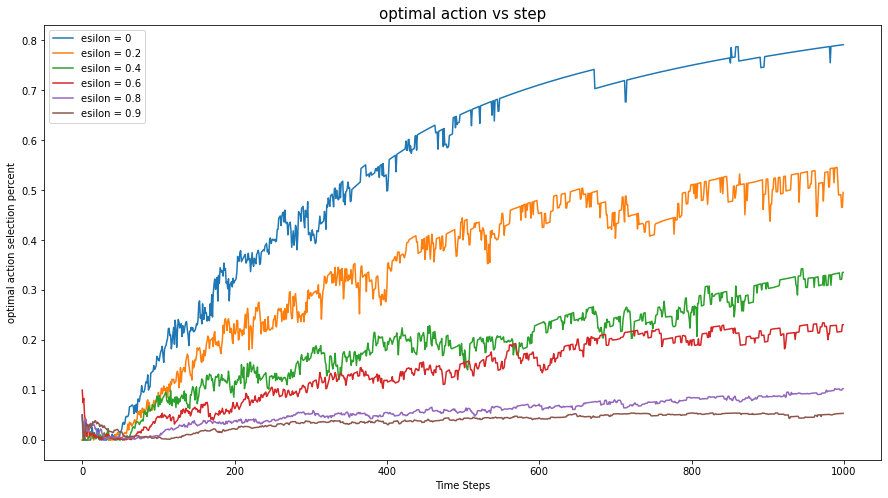

In [228]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 8))
index = 0
for i in all_mean_optimal_percent:
    
    plt.title('optimal action vs step', fontsize=15)
    plt.plot(i,label ="esilon = "+ str(epsilons[index]))
    plt.xlabel('Time Steps')
    plt.ylabel('optimal action selection percent')
    index +=1
plt.legend(loc='best')
plt.show()

### for epsilon = 0.2

In [416]:
all_reward = []
all_optimal = []
all_n =[]
for step in range(20):
    trial = 300
    epsilon = 0.2
    rewards = [NetReward(sid = 810199275) for i in range(48)]
    env = NetworkEnvironment(rewards, 10, '1')
    agent = RoutingAgentEpsilonPolicy('1', env, epsilon,trial)
    regret = 0
    
 
    for i in range(trial):
        regret, optimal , n, reward = agent.take_action()
    all_reward.append(reward)
    all_optimal.append(optimal)
    all_n.append(n)

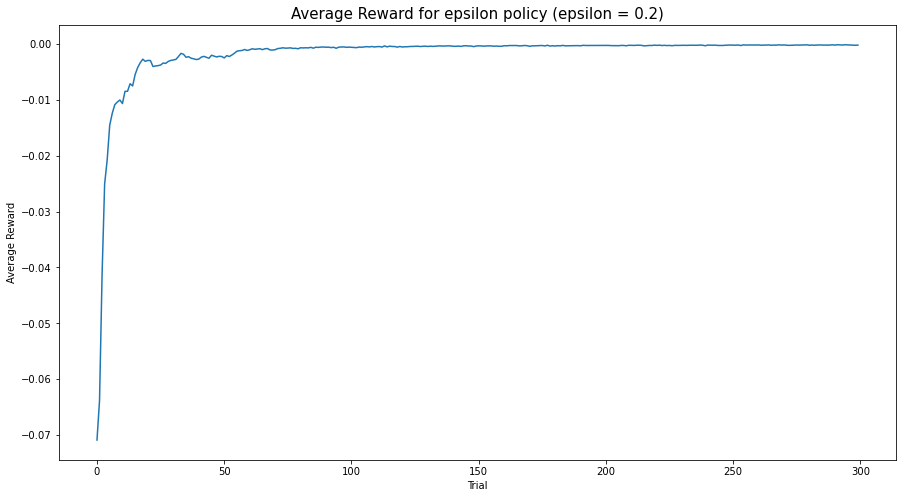

In [417]:
mean_all_n_epsilon = np.mean(all_n, axis=0)
mean_all_optimal_epsilon =np.mean(all_optimal, axis=0)
mean_all_reward_epsilon = np.mean(all_reward, axis=0)
plt.figure(figsize=(15, 8))
plt.title('Average Reward for epsilon policy (epsilon = 0.2)', fontsize=15)
plt.plot(mean_all_reward_epsilon)
plt.xlabel('Trial')
plt.ylabel('Average Reward')

plt.show()

In [418]:

link_path = ["a1,1,b1,5,c1,8,d1","a1,1,b1,5,c2,9,d2","a1,1,b1,5,c3,10,d3","a1,1,b1,5,c4,11,d4","a1,1,b2,6,c5,8,d1","a1,1,b2,6,c6,9,d2","a1,1,b2,6,c7,10,d3","a1,1,b2,6,c8,11,d4","a1,1,b3,7,c9,8,d1","a1,1,b3,7,c10,9,d2","a1,1,b3,7,c11,10,d3","a1,1,b3,7,c12,11,d4",
        "a2,2,b4,5,c1,8,d1","a2,2,b4,5,c2,9,d2","a2,2,b4,5,c3,10,d3","a2,2,b4,5,c4,11,d4","a2,2,b5,6,c5,8,d1","a2,2,b5,6,c6,9,d2","a2,2,b5,6,c7,10,d3","a2,2,b5,6,c8,11,d4","a2,2,b6,7,c9,8,d1","a2,2,b6,7,c10,9,d2","a2,2,b6,7,c11,10,d3","a2,2,b6,7,c12,11,d4",
        "a3,3,b7,5,c1,8,d1","a3,3,b7,5,c2,9,d2","a3,3,b7,5,c3,10,d3","a3,3,b7,5,c4,11,d4","a3,3,b8,6,c5,8,d1","a3,3,b8,6,c6,9,d2","a3,3,b8,6,c7,10,d3","a3,3,b8,6,c8,11,d4","a3,3,b9,7,c9,8,d1","a3,3,b9,7,c10,9,d2","a3,3,b9,7,c11,10,d3","a3,3,b9,7,c12,11,d4",
        "a4,4,b10,5,c1,8,d1","a4,4,b10,5,c2,9,d2","a4,4,b10,5,c3,10,d3","a4,4,b10,5,c4,11,d4","a4,4,b11,6,c5,8,d1","a4,4,b11,6,c6,9,d2","a4,4,b11,6,c7,10,d3","a4,4,b11,6,c8,11,d4","a4,4,b12,7,c9,8,d1","a4,4,b12,7,c10,9,d2","a4,4,b12,7,c11,10,d3","a4,4,b12,7,c12,11,d4"]
index =np.argmax(mean_all_n_epsilon)
print(f"we have minimum delay in this path --> {link_path[index]}")

we have minimum delay in this path --> a2,2,b4,5,c3,10,d3


In [458]:
from amalearn.agent import AgentBase

class RoutingAgentGradientPolicy(AgentBase):
    def __init__(self, id, environment,trials, alpha):
        super(RoutingAgentGradientPolicy, self).__init__(id, environment)
        
        self.actions_range = range(len(environment.arms_rewards))
        self.p = [(1/len(self.actions_range)) for i in self.actions_range]
        self.H = [0 for i in self.actions_range]
        self.avg_R = 0
        self.total_rewards = np.zeros(trials)
        self.alpha = alpha
        self.n = [0 for i in self.actions_range]
        self.optimal_action = np.zeros(trials)
        self.Q = [0 for i in self.actions_range]
        

        

    def reset(self):
        self.p = [(1/len(self.actions_range)) for i in self.actions_range]
        self.H = [0 for i in self.actions_range]
        self.avg_R = 0
        self.total_reward = 0
        self.n = [0 for i in self.actions_range]


    def update_H(self, index,Reward , alpha):
        self.n[index] += 1
        for i in self.actions_range:
            if i == index :
                self.H[i] =self.H[i] +alpha*(Reward - self.avg_R)*(1-self.p[i])
            else:
                self.H[i] =self.H[i] +alpha*(Reward - self.avg_R)*(self.p[i])
    
    def update_P(self):
        sum_H=0
        for i in self.H:
            sum_H = sum_H + i 
        for i in self.actions_range:
            self.p[i] = np.exp((self.H[i] + (sum_H )))



    def update_avg_R(self , reward,index):
        self.avg_R = (self.avg_R + (reward))/ sum(self.n)
        self.total_rewards[sum(self.n)-1] = self.avg_R
        self.Q[index] = self.Q[index]+ (1.0/(self.n[index]))*(reward - self.Q[index])
        

    def get_optimal(self, index_of_Q):
        self.optimal_action[sum(self.n)-1] = self.n[index_of_Q] / sum(self.n)



    def take_action(self) -> (object, float, bool, object):
        self.update_P()
        action = np.argmax(self.p)
        obs, r, d, i = self.environment.step(action)
        self.update_H(action,r,self.alpha)
        self.update_avg_R(r,action)
        index_Q = np.argmax(self.Q)
        self.get_optimal(index_Q)
        return self.total_rewards, self.n, self.optimal_action
       
        

In [459]:

all_rewards = []
all_n = []
all_optimal = []
for step in range(20):
    trial = 300
    rewards = [NetReward(sid = 810199275) for i in range(48)]
    env = NetworkEnvironment(rewards, 10, '1')
    agent = RoutingAgentGradientPolicy('1', env,  trial, 0.3)
    for i in range(trial):
        reward, n, optimal = agent.take_action()
    agent.reset()
    all_rewards.append(reward)
    all_n.append(n)
    all_optimal.append(optimal)

    print(f"try {step+1} :  \n actions selection count  {n}")





try 1 :  
 actions selection count  [16, 7, 9, 6, 6, 8, 9, 5, 4, 4, 5, 3, 12, 8, 10, 6, 12, 9, 11, 6, 6, 5, 5, 3, 10, 7, 7, 5, 5, 7, 9, 6, 4, 4, 5, 3, 6, 5, 6, 5, 4, 4, 5, 4, 3, 4, 4, 3]
try 2 :  
 actions selection count  [16, 8, 9, 5, 6, 6, 9, 7, 6, 5, 5, 4, 11, 7, 12, 7, 10, 8, 10, 6, 5, 5, 5, 4, 7, 7, 8, 6, 6, 8, 8, 6, 4, 4, 5, 4, 5, 7, 5, 4, 4, 4, 6, 4, 3, 3, 3, 3]
try 3 :  
 actions selection count  [18, 8, 10, 6, 8, 6, 7, 5, 5, 4, 5, 4, 11, 8, 8, 6, 9, 8, 9, 5, 4, 6, 4, 4, 8, 10, 8, 5, 7, 9, 7, 5, 4, 4, 4, 3, 7, 5, 8, 3, 6, 5, 6, 3, 4, 3, 4, 4]
try 4 :  
 actions selection count  [17, 8, 10, 5, 9, 7, 9, 5, 5, 4, 5, 3, 10, 12, 10, 5, 9, 11, 8, 5, 5, 5, 5, 3, 9, 8, 8, 6, 6, 6, 7, 6, 3, 3, 4, 3, 6, 6, 6, 4, 6, 6, 5, 4, 4, 3, 3, 3]
try 5 :  
 actions selection count  [17, 8, 9, 6, 8, 6, 10, 5, 5, 4, 4, 4, 11, 8, 10, 7, 9, 10, 10, 7, 6, 6, 5, 3, 9, 8, 7, 5, 6, 7, 8, 5, 4, 4, 4, 3, 6, 5, 6, 4, 4, 4, 5, 4, 4, 4, 3, 3]
try 6 :  
 actions selection count  [18, 9, 10, 7, 8, 6, 6, 5, 5, 5,

In [460]:
mean_all_rewards_UCB = np.mean(all_rewards, axis=0)
mean_all_n_UCB = np.mean(all_n, axis=0)
mean_all_optimal_UCB = np.mean(all_optimal, axis=0)

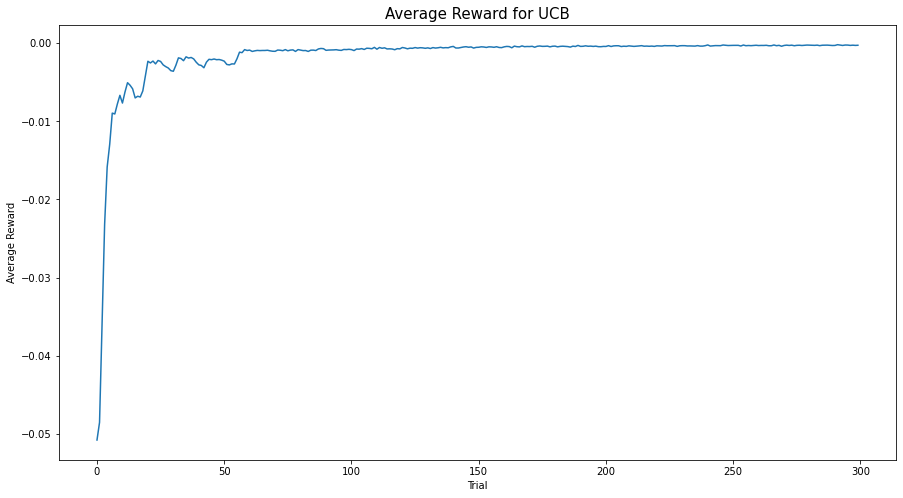

In [461]:
plt.figure(figsize=(15, 8))
plt.title('Average Reward for UCB', fontsize=15)
plt.plot(mean_all_rewards_UCB)
plt.xlabel('Trial')
plt.ylabel('Average Reward')

plt.show()

In [462]:
index =np.argmax(mean_all_n_UCB)
print(f"we have minimum delay in this path --> {link_path[index]}")

we have minimum delay in this path --> a1,1,b1,5,c1,8,d1


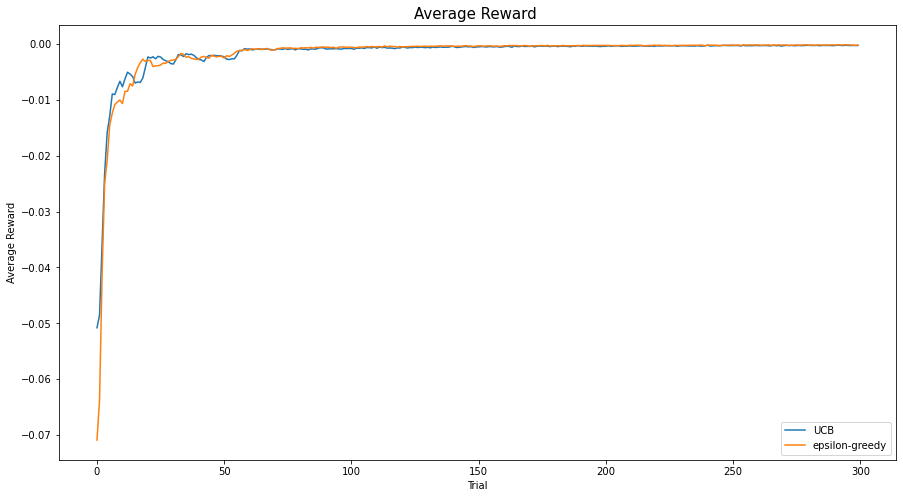

In [463]:
plt.figure(figsize=(15, 8))
plt.title('Average Reward ', fontsize=15)
plt.plot(mean_all_rewards_UCB, label= "UCB")
plt.plot(mean_all_reward_epsilon, label = "epsilon-greedy")
plt.xlabel('Trial')
plt.ylabel('Average Reward')

plt.legend()
plt.show()

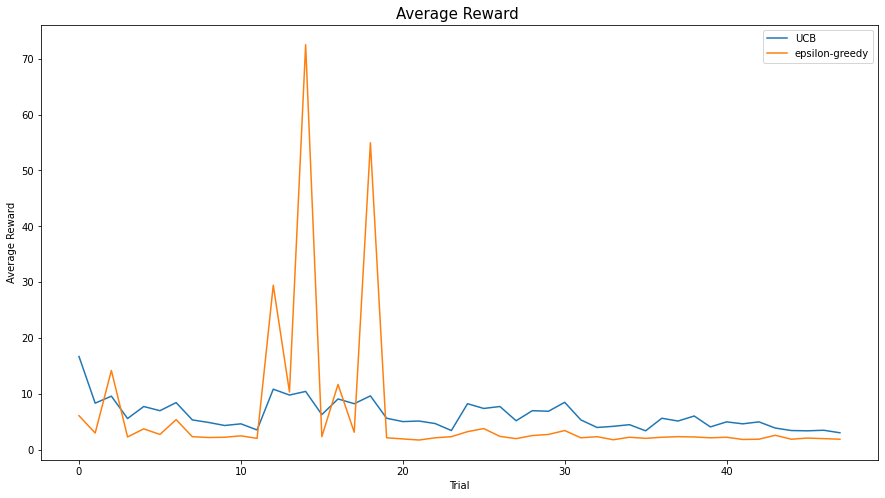

In [464]:
plt.figure(figsize=(15, 8))
plt.title('each action selection count vs action ', fontsize=15)
plt.plot(mean_all_n_UCB, label= "UCB")
plt.plot(men_all_n_epsilon, label = "epsilon-greedy")
plt.xlabel('Action')
plt.ylabel('each action selection count')

plt.legend()
plt.show()

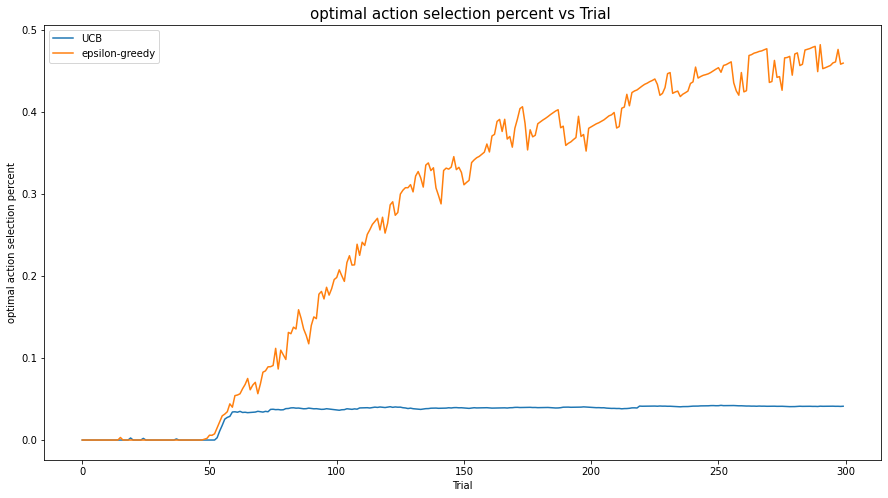

In [466]:
plt.figure(figsize=(15, 8))
plt.title('optimal action selection percent vs Trial ', fontsize=15)
plt.plot(mean_all_optimal_UCB, label= "UCB")
plt.plot(mean_all_optimal_epsilon, label = "epsilon-greedy")
plt.xlabel('Trial')
plt.ylabel('optimal action selection percent')

plt.legend()
plt.show()